# Image Features
We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

In [1]:
import random
import numpy as np
from exercise_code.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk. However, we don't apply our previous preprocessing steps, as we want to extract custom features later on.

Train data shape:  (48000, 32, 32, 3)
Train labels shape:  (48000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


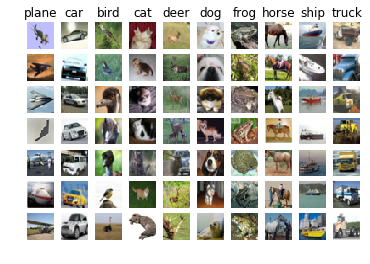

In [2]:
from exercise_code.data_utils import load_CIFAR10
from exercise_code.vis_utils import visualize_cifar10

def get_CIFAR10_data(num_training=48000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for feature extraction and training.
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'datasets/'
    X, y = load_CIFAR10(cifar10_dir)
    

    # Our training set will be the first num_train points from the original
    # training set.
    mask = range(num_training)
    X_train = X[mask]
    y_train = y[mask]
    
    # Our validation set will be num_validation points from the original
    # training set.
    mask = range(num_training, num_training + num_validation)
    X_val = X[mask]
    y_val = y[mask]
    
    # We use a small subset of the training set as our test set.
    mask = range(num_training + num_validation, num_training + num_validation + num_test)
    X_test = X[mask]
    y_test = y[mask]

    return X, y, X_train, y_train, X_val, y_val, X_test, y_test

# Invoke the above function to get our data.
X_raw, y_raw, X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

# visualize raw data
visualize_cifar10(X_raw, y_raw)

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from exercise_code.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000/48000 images
Done extracting features for 2000/48000 images
Done extracting features for 3000/48000 images
Done extracting features for 4000/48000 images
Done extracting features for 5000/48000 images
Done extracting features for 6000/48000 images
Done extracting features for 7000/48000 images
Done extracting features for 8000/48000 images
Done extracting features for 9000/48000 images
Done extracting features for 10000/48000 images
Done extracting features for 11000/48000 images
Done extracting features for 12000/48000 images
Done extracting features for 13000/48000 images
Done extracting features for 14000/48000 images
Done extracting features for 15000/48000 images
Done extracting features for 16000/48000 images
Done extracting features for 17000/48000 images
Done extracting features for 18000/48000 images
Done extracting features for 19000/48000 images
Done extracting features for 20000/48000 images
Done extracting features for 21000/48000 images
D

## Train a Softmax classifier on features
Using the multiclass Softmax code developed earlier in the assignment, train a Softmax classifier on top of the features extracted above; this should achieve better results than training the classifier directly on top of raw pixels.

In [64]:
# Use the validation set to tune the learning rate and regularization strength. You can 
# reuse the softmax_hyperparameter_tuning that you implemented in
# exercise_code.classifiers.softmax

from exercise_code.classifiers.softmax import SoftmaxClassifier, softmax_hyperparameter_tuning

best_softmax = None
results = {}
all_classifiers = []
################################################################################
# TODO: Train a softmax classifier on the features and tune hyperparameters to #
# obtain a strong model. You can alter and reuse the                           #
# softmax_hyperparameter_tuning function. Store your best network in the       #
# best_softmax variable.                                                       #
################################################################################
# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the
# fraction of data points that are correctly classified.
results = {}
best_val = -1
best_softmax = None
all_classifiers = []
learning_rates = [4e-7,3e-7,1e-7]
regularization_strengths = [2.5e4, 5e4, 2.5e5]

#as shown in the lecture:
for lr in learning_rates:
    for reg_str in regularization_strengths:
        # classifier
        model = SoftmaxClassifier()
        # train a classifier on the training set for each learning_rate = lr and regularization_strength = reg_str
        stats = model.train( X_train_feats, y_train, lr, reg_str, num_iters=2000, batch_size = 200, verbose=True)
        # add classifier to all_classifiers            
        all_classifiers.append(model)
        # compute predictions to use to compute accuracy
        train_predict = model.predict(X_train_feats)
        val_predict = model.predict(X_val_feats)

        # compute accuracy 
        train_acc = np.mean(y_train == train_predict)
        val_acc = np.mean(y_val == val_predict)

        #  store accuracies in the results dictionary
        results[(lr, reg_str)] = train_acc, val_acc   
#         # Predict on the validation set
#         plt.subplots(nrows=1, ncols=1)

#         plt.subplot(2, 1, 1)
#         plt.plot(stats)
#         plt.title('Loss history')
#         plt.xlabel('Iteration')
#         plt.ylabel('Loss')

#         plt.tight_layout()
#         plt.show()
        # store the best validation accuracy in best_val and the Softmax object that achieves this accuracy in best_softmax
        if(best_val<val_acc):
            best_val = val_acc
            best_softmax = model
           
# Print out results.
for (lr, reg) in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
          lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during validation: %f' % best_val)
print('all_classifiers', all_classifiers)


################################################################################
#                              END OF YOUR CODE                                #
################################################################################



iteration 0 / 2000: loss 21.240253
iteration 100 / 2000: loss 4.839802
iteration 200 / 2000: loss 2.642461
iteration 300 / 2000: loss 2.348036
iteration 400 / 2000: loss 2.308653
iteration 500 / 2000: loss 2.303398
iteration 600 / 2000: loss 2.302684
iteration 700 / 2000: loss 2.302583
iteration 800 / 2000: loss 2.302576
iteration 900 / 2000: loss 2.302568
iteration 1000 / 2000: loss 2.302570
iteration 1100 / 2000: loss 2.302569
iteration 1200 / 2000: loss 2.302572
iteration 1300 / 2000: loss 2.302572
iteration 1400 / 2000: loss 2.302572
iteration 1500 / 2000: loss 2.302568
iteration 1600 / 2000: loss 2.302570
iteration 1700 / 2000: loss 2.302569
iteration 1800 / 2000: loss 2.302573
iteration 1900 / 2000: loss 2.302571
iteration 0 / 2000: loss 41.779073
iteration 100 / 2000: loss 2.996928
iteration 200 / 2000: loss 2.314794
iteration 300 / 2000: loss 2.302791
iteration 400 / 2000: loss 2.302584
iteration 500 / 2000: loss 2.302577
iteration 600 / 2000: loss 2.302578
iteration 700 / 2000

In [60]:
# Evaluate your trained classifier on the test set
y_test_pred = best_softmax.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.403


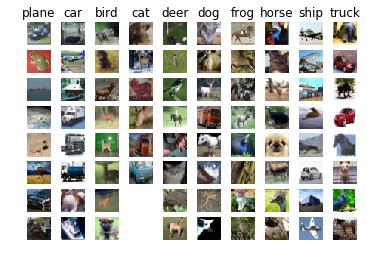

In [61]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    if len(idxs) > 0:
        idxs = np.random.choice(idxs, min(examples_per_class, len(idxs)), replace=False)
    else:
        idxs = []
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

<div class="alert alert-info">
    <h3>Inline Question</h3>
    <p>Describe the misclassification results that you see. Do they make sense?</p>
</div>

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set.

Note that in the neural net class we have used explicit biases. In the preprocessing of this exercise we have also added a bias dimension to the input, such that we don't have to consider an explicit bias in the linear classifier above. The neural net therefore has an additional parameter in the first layer (the additional bias term), which after all does not matter, as both bias terms can be learned. So just don't get confused by this.

lr:  0.9  lrd:  0.95 reg:  0


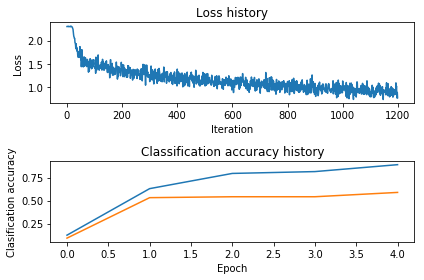

lr:  0.9  lrd:  0.95 reg:  0.005


In [ ]:
from exercise_code.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

#net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# validate various parameters as in previous sections. Store your best         #
# model in the best_net variable.                                              #
################################################################################
results = {}
learning_rates = [9e-1,1,0.97] 
iterations = 1200
val_acc=-1
train_acc = -1
learning_rate_decays = [0.95]
regularization_strengths = [0, 0.005,1e-4]
epochs =2 
for epoch in range(epochs):
    for learning_rate in learning_rates:
        for learning_rate_decay in learning_rate_decays:   
            for reg in regularization_strengths:
                print('lr: ', learning_rate, ' lrd: ',learning_rate_decay, 'reg: ', reg) 
                net = TwoLayerNet(input_dim, hidden_dim, num_classes)

                stats = net.train(X_train_feats, y_train, X_val_feats, y_val, learning_rate, learning_rate_decay, reg, iterations, batch_size=200, verbose=False)
                all_classifiers.append(net)

                train_predict = net.predict(X_train_feats)
                val_predict = net.predict(X_val_feats)

                train_acc = np.mean(y_train == train_predict)
                val_acc = np.mean(y_val == val_predict)

                results[(learning_rate, reg)] = train_acc, val_acc   
                
                if(best_val<val_acc):
                    best_val = val_acc
                    best_net = net
                plt.subplots(nrows=2, ncols=1)
                plt.subplot(2, 1, 1)
                plt.plot(stats['loss_history'])
                plt.title('Loss history')
                plt.xlabel('Iteration')
                plt.ylabel('Loss')

                plt.subplot(2, 1, 2)
                plt.plot(stats['train_acc_history'], label='train')
                plt.plot(stats['val_acc_history'], label='val')
                plt.title('Classification accuracy history')
                plt.xlabel('Epoch')
                plt.ylabel('Clasification accuracy')

                plt.tight_layout()
                plt.show()        

# Print out results.
for (learning_rate, reg) in sorted(results):
    train_accuracy, val_accuracy = results[(learning_rate, reg)]
    print('learning_rate %e reg %e  train accuracy: %f val accuracy: %f' % (
          learning_rate, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during validation: %f achieved with learning rate %e and regularization %f' % (best_val,learning_rate,reg))




################################################################################
#                              END OF YOUR CODE                                #
################################################################################

In [79]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (net.predict(X_test_feats) == y_test).mean()
print("Test accuracy: ", test_acc)

Test accuracy:  0.515


## Save the model

When you are satisfied with your training, save the model for submission. In order to pass this exercise, you have to score more than __55__ points.

In [ ]:
from exercise_code.model_savers import save_feature_neural_net
save_feature_neural_net(best_net)